In [156]:
import functools
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Configuración de dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###UNet sub-modules

In [157]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class DoubleConvLeaky(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)



class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class DownLeaky(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConvLeaky(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class Up_v2(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, mid_channels):
        super().__init__()

        # # if bilinear, use the normal convolutions to reduce the number of channels
        # self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        # self.conv = DoubleConv(in_channels, out_channels, mid_channels)

        self.up = nn.ConvTranspose2d(in_channels//2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels, mid_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        # self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.conv(x)


### UNet architecture

In [158]:
# Source paper: Deep Learning to Obtain Simultaneous Image and Segmentation Outputs From a Single Input of Raw Ultrasound Channel Data
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

        # placeholder for the gradients and activations
        self.gradients = None
        self.activations = None

    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        # We get the activations and gradients from the layer of interest (layer up4 in this case)
        h = x.register_hook(self.activations_hook)
        self.activations = x.clone().detach()

        logits = self.outc(x)
        return logits

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients

    # method for the activation exctraction
    def get_activations(self, x):
        return self.activations

# model = UNet(n_channels=2, n_classes=1).to(device)

#input = N_batchsxN_channelsxHxW
#input = 1x2x800x128

### Load the data

(800, 128, 2)
torch.Size([1, 2, 800, 128]) 
 torch.float32


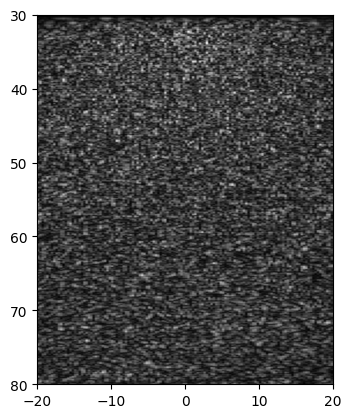

In [159]:
model = UNet(n_channels=2, n_classes=1)
model.load_state_dict(torch.load('/content/drive/MyDrive/Proyecto Grad CAM/UNet GradCAM/model_0049.t7', map_location=torch.device('cpu')))

# Cargamos un dato
sample = np.load('/content/drive/MyDrive/Proyecto Grad CAM/UNet GradCAM/input_id/simu00001.npy')
print(sample.shape)

# Convertimos a tensor con las dimensiones en el orden correcto y tipo float32
input_tensor = torch.tensor(sample, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
print(input_tensor.size(), '\n', input_tensor.dtype)

extent_full = [-20, 20, 80, 30]
opts = {"extent": extent_full, "origin": "upper"}

nrg = np.sqrt((input_tensor[:,0,:,:]**2) + (input_tensor[:,1,:,:]**2))
nrg = nrg.squeeze()

plt.imshow(nrg, **opts, cmap='gray')

### GradCAM implementation

torch.Size([1, 1, 800, 128])
torch.Size([64])
torch.Size([1, 64, 800, 128])
torch.Size([800, 128])


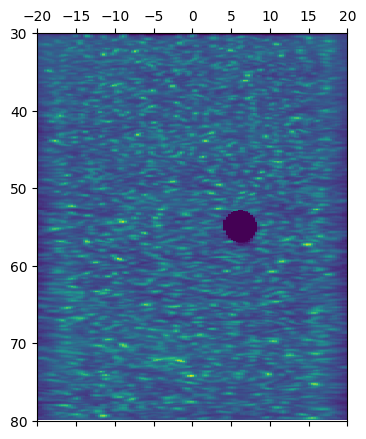

In [160]:
# We get the output
model.eval()
output = model(input_tensor)
print(output.size())

# Then get the gradient of the output pixel in location length=400 and width 64, with respect to the parameters of the model
output[:, :, 400, 64].backward()

# pull the gradients out of the model
gradients = model.get_activations_gradient()
# print('GRADIENTS: \n',gradients.size(), '\n', gradients.max(), gradients.min())

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
print(pooled_gradients.size())

# get the activations of the last convolutional layer
activations = model.get_activations(input_tensor).detach()
print(activations.size())

# weight the channels by corresponding gradients
for i in range(64):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)
print(heatmap.size())

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap, **opts)

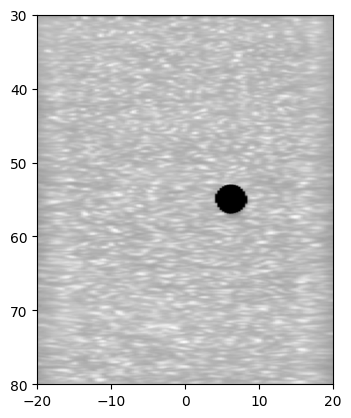

In [161]:
plt.imshow(output.detach().squeeze(), **opts, cmap='gray')